In [2]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

sys.path.append("../..")

from gemini.utils import *
from drift_detector.rolling_window import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-08-31 02:39:49,889 INFO cyclops.orm     - Database setup, ready to run queries!


In [3]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
threshold=0.05
num_timesteps = 6
run=1
shift="simulated_deployment"
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH","PMH"]
outcome="mortality"
aggregation_type="time"
scale=True

In [4]:
admin_data, x, y = get_gemini_data(PATH)

numerical_cols = get_numerical_cols(PATH)
for col in numerical_cols:
    scaler = StandardScaler().fit(x[col].values.reshape(-1, 1))
    x[col] = pd.Series(
        np.squeeze(scaler.transform(x[col].values.reshape(-1, 1))),
        index=x[col].index,
    )
X = reshape_inputs(x, num_timesteps)

2022-08-31 02:39:49,968 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-08-31 02:39:50,404 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-08-31 02:39:50,588 INFO cyclops.feature_handler - Loading features from file...
2022-08-31 02:39:50,596 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-31 02:39:50,602 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-31 02:39:50,640 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-08-31 02:39:55,804 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-08-31 02:40:05,037 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet
2022-08-31 02:40:26,870 INFO cyclops.feature_handler - Loading features from file...
2022-08-31 02:40:26,882 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-31 02:40:26,889 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-31 02:40:26,932 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-31 02:40:32,343 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


In [5]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, admin_data = import_dataset_hospital(admin_data, x, y, shift, outcome, hospital, run, shuffle=True)

random.seed(1)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, num_timesteps, x_train, y_train, x_val, y_val, x_test, y_test)
# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, num_timesteps, X_tr_normalized, X_val_normalized, X_t_normalized)

## Create Data Streams

In [6]:
start_date = date(2019, 1, 1)
end_date = date(2020, 8, 1)

val_ids=list(X_val_normalized.index.get_level_values(0).unique())

x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1, ids_to_exclude=val_ids)

2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Dynamic Rolling Window

In [16]:
# rolling window parameters
threshold = 0.05
num_timesteps = 6
stat_window=30
retrain_window=120
lookup_window=0
stride=1
model_name="rnn"
retrain="update"

# model parameters
output_dim = 1
batch_size = 64
input_dim = 108
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False
device = get_device()
model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

#drift detector parameters
dr_technique="BBSDs_trained_LSTM"
model_path=os.path.join(os.getcwd(),"../../saved_models/"+shift+"_lstm.pt")
md_test="MMD"
sign_level=0.05
sample=100
dataset="gemini"
context_type="rnn"
representation="rnn"

# Get shift reductor
shift_reductor = ShiftReductor(
    X_tr_final, y_tr, dr_technique, dataset, var_ret=0.8, model_path=model_path,
)
# Get shift detector
shift_detector = ShiftDetector(
    dr_technique, md_test, sign_level, shift_reductor, sample, dataset, feats, model_path, context_type, representation,
)

if model_name == "rnn":
    model = get_temporal_model("lstm", model_params).to(device)
    
    if retrain=="update":
        checkpoint_fpath = os.path.join(os.getcwd(),'../../saved_models/',shift+"_lstm.pt")
        model, opt, n_epochs = load_ckp(checkpoint_fpath, model)
        n_epochs = 1
    else:
        n_epochs = 64
        loss_fn = nn.BCEWithLogitsLoss(reduction="none")
        optimizer = optim.Adagrad(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
        activation = nn.Sigmoid()
        opt = Optimizer(
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            activation=activation,
            lr_scheduler=lr_scheduler,
        )
if model_name == "gbt":
    with open(model_path, 'rb') as f:
        model = pickle.load(f)    

retrain_parameters = {'stat_window':stat_window,
                     'retrain_window':retrain_window,
                     'stride':stride,
                     'drift_threshold':drift_threshold,
                     'retrain_type':retrain_type,
                     'sample':sample,
                     'verbose':verbose,
                     'shift_detector':shift_detector}

model_parameters = {'model_name':model_name,
                   'model':model,
                   'optimizer':optimizer,
                   'num_timesteps': num_timesteps,
                   'batch_size':batch_size,
                    'n_epochs':n_epochs,
                   'input_dim':input_dim}

data_parameters = {'X_train':X_train,
                   'X_val':X_val,
                   'y_val':y_val,
                   'X_test':X_test_stream,
                   'y_test':y_test_stream}

#####################################################
## dynamically adjusting drift detector - if drift is significant, reference dataset is reset to current time 
#####################################################


def dynamic_rolling_window(retrain_parameters, model_parameters, data_parameters):
    
    p_vals = []
    dist_vals = []
    rolling_metrics = []
    run_length = retrain_parameters['stat_window'] 
    i = retrain_parameters['stat_window'] 
    p_val = 1
    val_dataset = get_data(data_parameters['X_val'], data_parameters['y_val'])
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=model_parameters['batch_size'] , shuffle=False)
    X_ref = data_parameters['X_val']
    
    while i+retrain_parameters['stat_window']+retrain_parameters['lookup_window']  <= len(data_parameters['X_test']):
        feat_index = 0
        
        if p_val < retrain_parameters['drift_threshold'] :
            
            if retrain_parameters['retrain_type'] is not None:
                X_update = pd.concat(data_parameters['X_test'][max(int(i)-run_length,0):int(i)])
                X_update = X_update[~X_update.index.duplicated(keep='first')]
                ind = X_update.index.get_level_values(0).unique()
                X_update = reshape_inputs(X_update, model_parameters['num_timesteps'])

                ## Get updated source data for two-sample test (including data for retraining) 
                X_ref = np.concatenate((X_ref, X_update), axis=0)
                tups = [tuple(row) for row in X_ref]
                X_ref = np.unique(tups, axis=0)
                np.random.shuffle(X_ref)                 

                y_update = pd.concat(y_stream[max(int(i)-run_length,0):int(i)])
                y_update.index = ind
                y_update = y_update[~y_update.index.duplicated(keep='first')].to_numpy()

                if verbose:
                    print("Retrain ",model_parameters['model_name']," on: ",max(int(i)-run_length,0),"-",int(i))

                if model_parameters['model_name'] == "rnn":
                    ## create train loader 
                    update_dataset = get_data(X_update, y_update)
                    update_loader = torch.utils.data.DataLoader(update_dataset, batch_size=model_parameters['batch_size'], shuffle=False)

                    retrain_model_path='mostrecent120_1epoch_n100_window_retrain.model'

                    ## train 
                    opt.train(
                         update_loader,
                         val_loader,
                         batch_size=model_parameters['batch_size'],
                         n_epochs=model_parameters['n_epochs'],
                         n_features=model_parameters['input_dim'],
                         timesteps=model_parameters['num_timesteps'],
                         model_path=retrain_model_path,
                    )

                    model.load_state_dict(torch.load(retrain_model_path))
                    opt.model = model
                    shift_detector.model_path = retrain_model_path

                elif model_parameters['model_name'] == "gbt":
                    model = model.fit(X_retrain, y_retrain, xgb_model=model.get_booster())

                else:
                    print("Invalid Model Name")

            i += retrain_parameters['stride']
            
        X_next = pd.concat(data_parameters['X_test'][max(int(i)+retrain_parameters['lookup_window'],0):int(i)+retrain_parameters['stat_window']+retrain_parameters['lookup_window']])
        X_next = X_next[~X_next.index.duplicated(keep='first')]
        next_ind = X_next.index.get_level_values(0).unique()
        X_next = reshape_inputs(X_next, model_parameters['num_timesteps'])
        
        y_next = pd.concat(data_parameters['y_test'][max(int(i)+retrain_parameters['lookup_window'],0):int(i)+retrain_parameters['stat_window']+retrain_parameters['lookup_window']])
        y_next.index = next_ind
        y_next = y_next[~y_next.index.duplicated(keep='first')].to_numpy()
        
        if X_next.shape[0]<=2 or X_ref.shape[0]<=2:
            break

        ## Check Performance 
        test_dataset = get_data(X_next, y_next)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        y_test_labels, y_pred_values, y_pred_labels = model_parameters['optimizer'].evaluate(
            test_loader, batch_size=1, n_features=model_parameters['input_dim'], timesteps=model_parameters['num_timesteps'] 
        )
        assert y_test_labels.shape == y_pred_labels.shape == y_pred_values.shape
        y_pred_values = y_pred_values[y_test_labels != -1]
        y_pred_labels = y_pred_labels[y_test_labels != -1]
        y_test_labels = y_test_labels[y_test_labels != -1]  
        pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels, verbose=0)
        rolling_metrics.append(pd.DataFrame(pred_metrics.values(),index=pred_metrics.keys()).T)
        
        ## Detect Distribution Shift 
        (p_val, dist, val_acc, te_acc) = retrain_parameters['shift_detector'].detect_data_shift(data_parameters['X_train'], 
                                                                          X_ref[:1000,:], 
                                                                          X_next[:retrain_parameters['sample'] ,:]
        )

        if retrain_parameters['verbose']:
            print("Drift on ",max(int(i)+retrain_parameters['lookup_window'],0),"-",int(i)+retrain_parameters['stat_window']+retrain_parameters['lookup_window']," P-Value: ",p_val,)
            
        dist_vals.append(dist)
        p_vals.append(p_val)

        if p_val >= retrain_parameters['drift_threshold']:
            run_length += retrain_parameters['stride'] 
            i += retrain_parameters['stride'] 
        else:
            run_length= retrain_parameters['retrain_window'] 

    rolling_metrics = pd.concat(rolling_metrics).reset_index(drop=True)
    
    return dist_vals, p_vals, rolling_metrics

## get n_alarms function
## 

## Run retraining experiment

In [17]:
all_runs = []
import numpy as np, scipy.stats as st
for i in range(0,5):
    np.random.seed(1)
    random.seed(1)
    dist_test, pvals_test, performance_metrics, total_alarms = dynamic_rolling_window(X_tr_final, x_test_stream, y_test_stream, shift_detector, sample, stat_window, retrain_window, lookup_window, stride, num_timesteps, threshold, model_name, model, opt, X_val_final, y_val, retrain)
    run_dict= {"dist":dist_test,"pval":pvals_test,"performance":performance_metrics,"alarms":total_alarms}
    all_runs.append(run_dict)
    mean = np.mean(pvals_test[pvals_test<0.05])
    ci = st.t.interval(0.95, len(pvals_test[pvals_test<0.05])-1, loc=np.mean(pvals_test[pvals_test<0.05]), scale=st.sem(pvals_test[pvals_test<0.05]))
    print(total_alarms, " alarms with avg p-value of ", mean, ci)
    np.save(os.path.join(PATH, shift, shift+"_mostrecent120_1epoch_n100_retraining_update.npy"), all_runs)

Retrain  rnn  on:  0 - 31
[1/1] Training loss: 0.8506	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 32
[1/1] Training loss: 0.9398	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 33
[1/1] Training loss: 0.9131	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 34
[1/1] Training loss: 0.9115	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 35
[1/1] Training loss: 0.8133	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 40
[1/1] Training loss: 0.9065	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 41
[1/1] Training loss: 0.9012	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 42
[1/1] Training loss: 0.9287	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 43
[1/1] Training loss: 0.8895	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 44
[1/1] Training loss: 0.9624	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 45
[1/1] Training loss: 0.8798	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 46
[1/1] Training loss: 0.9234	 Validation loss: 1.0838
Retrain  rnn  on:  0 - 47
[1/1] Training loss: 0.892

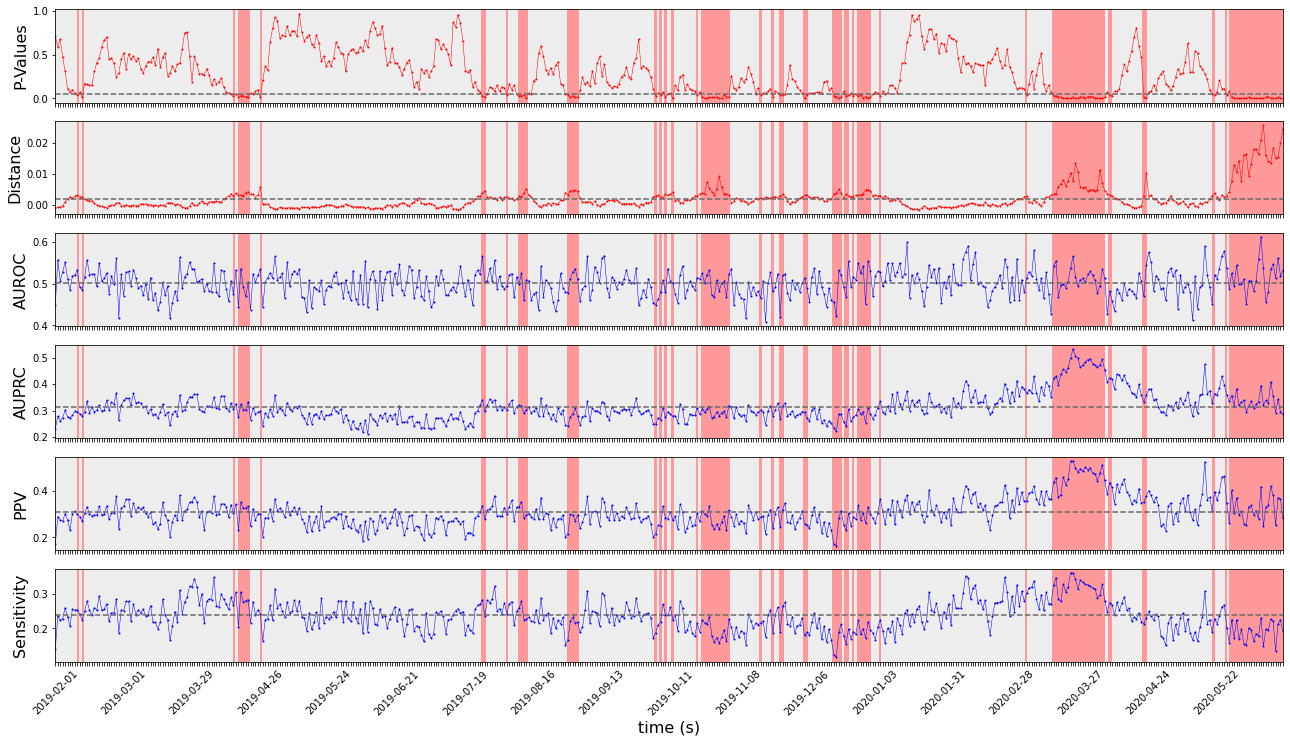

In [9]:
end = performance_metrics.shape[0]
threshold=0.05
measure_dates_test_adjust = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(22,12))
results = pd.DataFrame(
    {'dates': measure_dates_test_adjust[0:end],
     'pval': pvals_test[0:end],
     'dist': dist_test[0:end],
     'detection': np.where(pvals_test[0:end]<threshold,1,0)
    })
results = pd.concat([results,performance_metrics],axis=1)
results.to_pickle(os.path.join(PATH,shift,shift+"_"+dr_technique+"_"+md_test+"_results.pkl")) 
start = 0 
end = performance_metrics.shape[0]-1
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['dates'], results['pval'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['dates'][start], results['dates'][end])
ax1.axhline(y=threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
  
ax2.plot(results['dates'], results['dist'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['dates'][start], results['dates'][end])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['dist']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax3.plot(results['dates'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['dates'][start], results['dates'][end])
ax3.set_ylabel('AUROC', fontsize=16)
ax3.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax4.plot(results['dates'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['dates'][start], results['dates'][end])
ax4.set_ylabel('AUPRC',fontsize=16)
ax4.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax5.plot(results['dates'], results['prec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['dates'][start], results['dates'][end])
ax5.set_ylabel('PPV', fontsize=16)
ax5.axhline(y=np.mean(results['prec1']), color='dimgrey', linestyle='--')
ax5.set_xticklabels([])
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax6.plot(results['dates'], results['rec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax6.set_xlim(results['dates'][start], results['dates'][end])
ax6.set_ylabel('Sensitivity',fontsize=16)
ax6.set_xlabel('time (s)', fontsize=16)
ax6.axhline(y=np.mean(results['rec1']), color='dimgrey', linestyle='--')
ax6.tick_params(axis='x', labelrotation=45)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax6.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()